In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy

from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report, mean_squared_error, r2_score

In [2]:
# loading the english model of the NLP library spacy
nlp = spacy.load("en", disable=['parser', 'tagger', 'ner'])

In [3]:
df = pd.read_csv('winemag-data-130k-v2.csv', index_col=0)

In [4]:
#--------------------------------------Exploring The Dataset----------------------------------------#

In [5]:
df.shape

(129971, 13)

In [6]:
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [7]:
df.describe(include = 'all')

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
count,129908,129971,92506,129971.000000,120975.000000,129908,108724,50511,103727,98758,129971,129970,129971
unique,43,119955,37979,NaN,NaN,425,1229,17,19,15,118840,707,16757
top,US,"Stalky aromas suggest hay and green herbs, wit...",Reserve,NaN,NaN,California,Napa Valley,Central Coast,Roger Voss,@vossroger,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,Pinot Noir,Wines & Winemakers
freq,54504,3,2009,NaN,NaN,36247,4480,11065,25514,25514,11,13272,222
mean,NaN,NaN,NaN,88.447138,35.363389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,3.039730,41.022218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,80.000000,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,86.000000,17.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,88.000000,25.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,91.000000,42.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Checking percentage of null entries in each column
df.isnull().sum() / len(df) * 100

country                   0.048472
description               0.000000
designation              28.825661
points                    0.000000
price                     6.921544
province                  0.048472
region_1                 16.347493
region_2                 61.136715
taster_name              20.192197
taster_twitter_handle    24.015357
title                     0.000000
variety                   0.000769
winery                    0.000000
dtype: float64

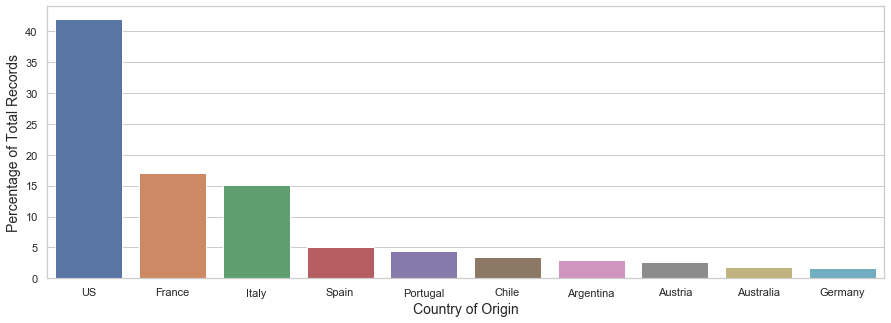

In [9]:
# Country
# Visualize percentage of data entries with wines of top 10 countries of origin
series=(df['country'].value_counts() / len(df))[:10]
plt.figure(figsize=(15,5))
sns.set(style="whitegrid")
ax = sns.barplot(x=series.index , y=series.values*100)
ax.set_xlabel("Country of Origin",fontsize=14)
ax.set_ylabel("Percentage of Total Records",fontsize=14)
plt.show()

In [10]:
# wines reviewed from top 10 (out of 43) countries cover 95.9% of all reviews in the dataset
df['country'].value_counts()[:10].sum()/df['country'].count()

0.9590171505988854

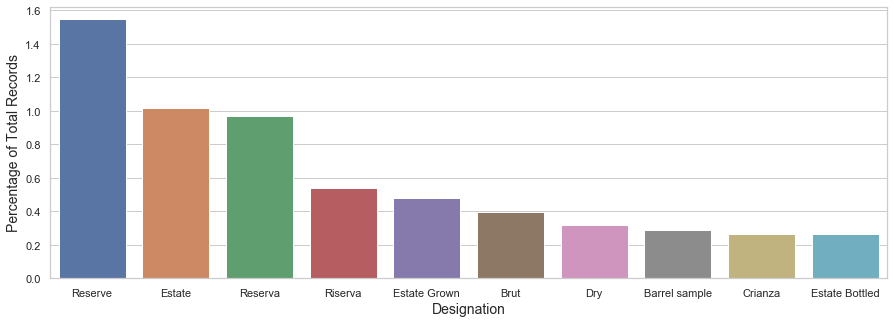

In [11]:
# Designation
# Visualize percentage of data entries of top 10 vineyards within the winery where the grapes were from.
series=(df['designation'].value_counts().head(10) / len(df))
plt.figure(figsize=(15,5))
sns.set(style="whitegrid")
ax = sns.barplot(x=series.index , y=series.values*100)
ax.set_xlabel("Designation",fontsize=14)
ax.set_ylabel("Percentage of Total Records",fontsize=14)
plt.show()

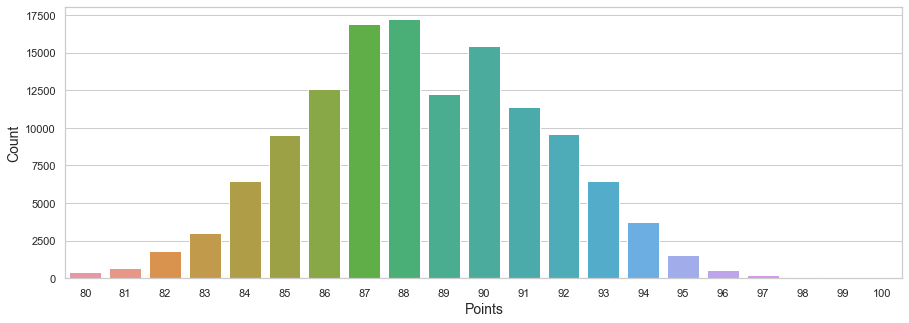

In [12]:
# Points
# Visualize the distribution of points in the data entries.
series=df['points'].value_counts().sort_index()
plt.figure(figsize=(15,5))
sns.set(style="whitegrid")
ax = sns.barplot(x=series.index , y=series.values)
ax.set_xlabel("Points",fontsize=14)
ax.set_ylabel("Count",fontsize=14)
plt.show()

In [13]:
# Out of the 21 values of points, 6 points in the middle [86,91] have 66% of the data.
df['points'].value_counts().sort_index()[6:12].sum() / len(df)

0.6596471520569973

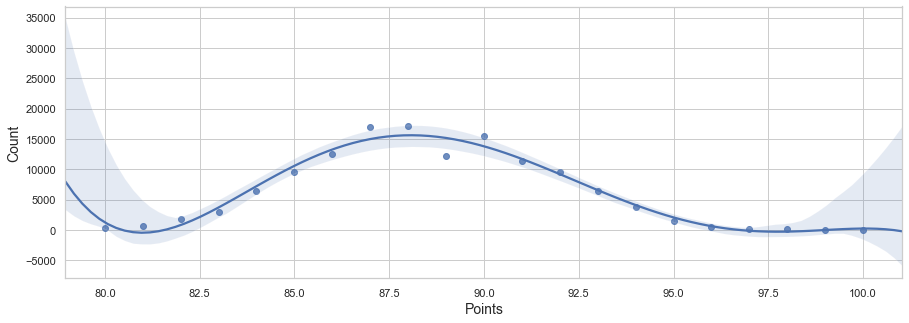

In [14]:
# Points
# Fitting a regression plot on the count vs points graph
series=df['points'].value_counts().sort_index()
plt.figure(figsize=(15,5))
sns.set(style="whitegrid")
ax = sns.regplot(x=[int(i) for i in series.index], y=series.values, order=5)
ax.set_xlabel("Points",fontsize=14)
ax.set_ylabel("Count",fontsize=14)
plt.show()

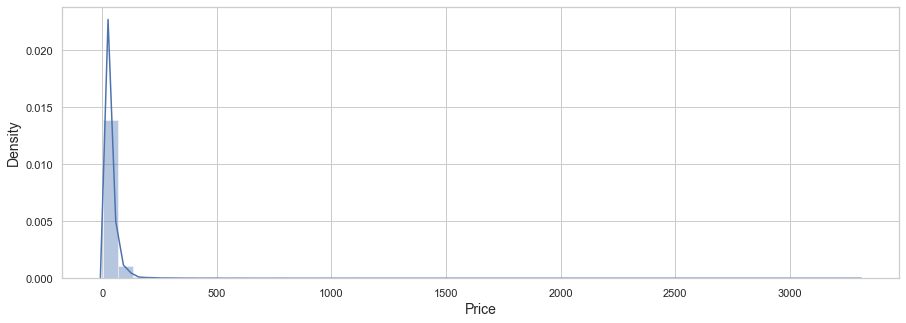

In [15]:
# Price
# Visualize the distribution of price in the data entries.
series=df[~df['price'].isnull()]['price']
plt.figure(figsize=(15,5))
sns.set(style="whitegrid")
ax = sns.distplot(series)
ax.set_xlabel("Price",fontsize=14)
ax.set_ylabel("Density",fontsize=14)
plt.show()

In [16]:
# 98.98% of price listings are less than equal to 150
df[(df['price']<=150)]['price'].count() / df['price'].count()

0.989824343872701

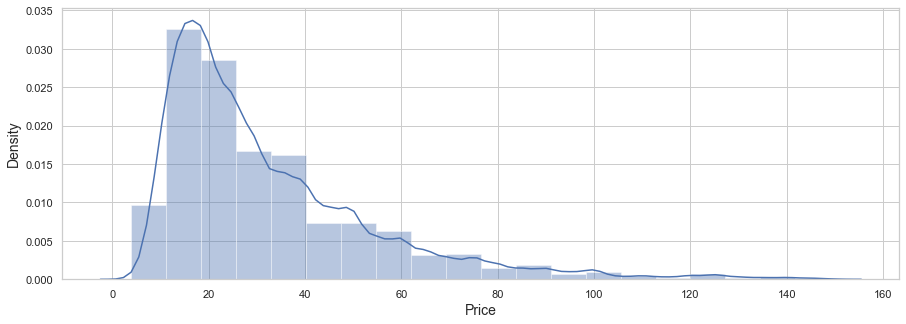

In [17]:
# Price again
# As in the plot above, most of the prices are less than 150, visualising only them closely
series=df[df['price']<150]['price']
plt.figure(figsize=(15,5))
sns.set(style="whitegrid")
ax = sns.distplot(series, bins=20)
ax.set_xlabel("Price",fontsize=14)
ax.set_ylabel("Density",fontsize=14)
plt.show()

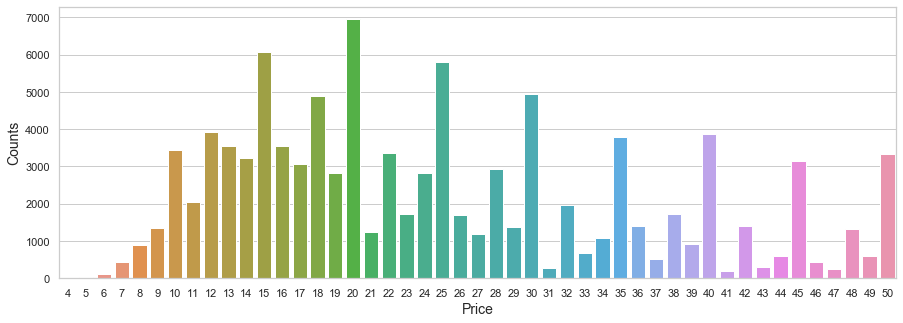

In [18]:
# Price again
# Visualize data with individual prices less than 50.
series=df[df['price']<=50]['price'].astype(int).value_counts().sort_index()
plt.figure(figsize=(15,5))
sns.set(style="whitegrid")
ax = sns.barplot(x=series.index, y=series.values)
ax.set_xlabel("Price",fontsize=14)
ax.set_ylabel("Counts",fontsize=14)
plt.show()

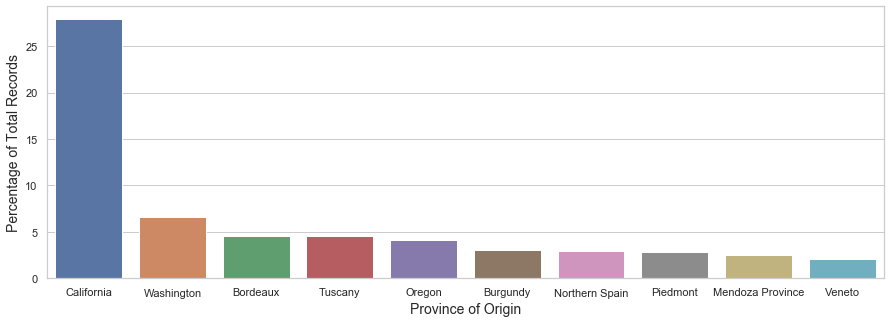

In [19]:
# Province
# Visualize percentage of data entries with wines of top 10 provinces/states of origin
series=(df['province'].value_counts().head(10) / len(df))
plt.figure(figsize=(15,5))
sns.set(style="whitegrid")
ax = sns.barplot(x=series.index , y=series.values*100)
ax.set_xlabel("Province of Origin",fontsize=14)
ax.set_ylabel("Percentage of Total Records",fontsize=14)
plt.show()

In [20]:
len(pd.Series.unique(df['title']))

118840

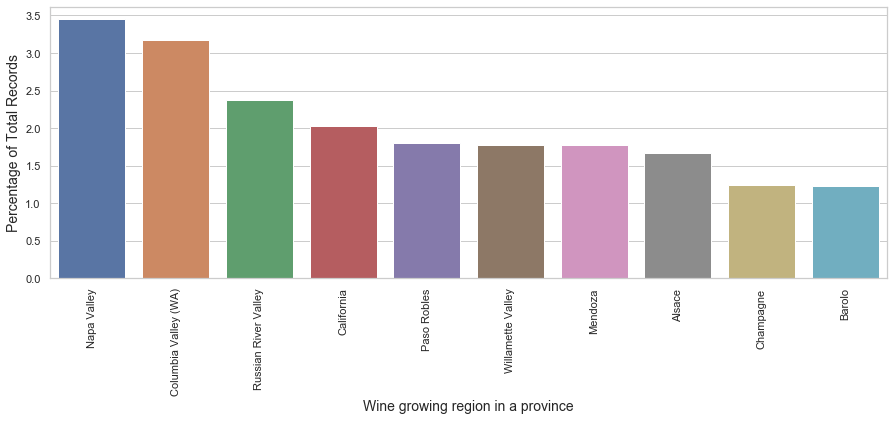

In [21]:
# Region 1
# Visualize percentage of data entries with wines of top 10 wine growing areas inside a region in a province/state
series=(df['region_1'].value_counts().head(10) / len(df))
plt.figure(figsize=(15,5))
sns.set(style="whitegrid")
ax = sns.barplot(x=series.index , y=series.values*100)
ax.set_xlabel("Wine growing region in a province",fontsize=14)
ax.set_ylabel("Percentage of Total Records",fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

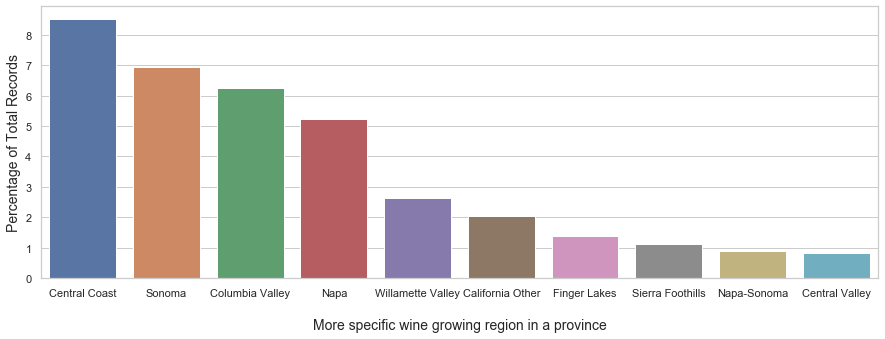

In [22]:
# Region 2
# Visualize percentage of data entries with wines of top 10 more specific wine growing regions in a province/state
series=(df['region_2'].value_counts().head(10) / len(df))
plt.figure(figsize=(15,5))
sns.set(style="whitegrid")
ax = sns.barplot(x=series.index , y=series.values*100)
ax.set_xlabel("\nMore specific wine growing region in a province",fontsize=14)
ax.set_ylabel("Percentage of Total Records",fontsize=14)
plt.show()

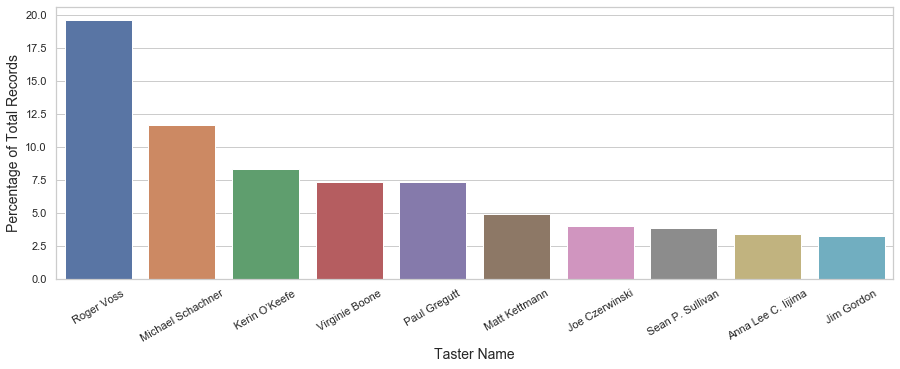

In [23]:
# Taster Name
# Visualize percentage of data entries reviewed by different tasters (showing only top 10)
series=(df['taster_name'].value_counts().head(10) / len(df))
plt.figure(figsize=(15,5))
sns.set(style="whitegrid")
ax = sns.barplot(x=series.index , y=series.values*100)
ax.set_xlabel("Taster Name",fontsize=14)
ax.set_ylabel("Percentage of Total Records",fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.show()

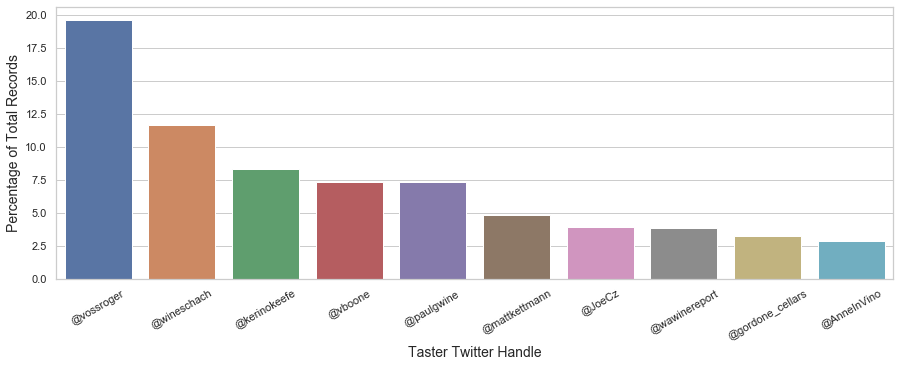

In [24]:
# Taster Twitter Handle
# Visualize percentage of data entries reviewed by different tasters (showing only top 10)
series=(df['taster_twitter_handle'].value_counts().head(10) / len(df))
plt.figure(figsize=(15,5))
sns.set(style="whitegrid")
ax = sns.barplot(x=series.index , y=series.values*100)
ax.set_xlabel("Taster Twitter Handle",fontsize=14)
ax.set_ylabel("Percentage of Total Records",fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.show()

In [25]:
# One of the top tasters "Anna Lee C. Iijima" didn't enter her twitter handle
df[(~df['taster_twitter_handle'].isnull() & df['taster_name'].str.startswith('Anna'))]

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery


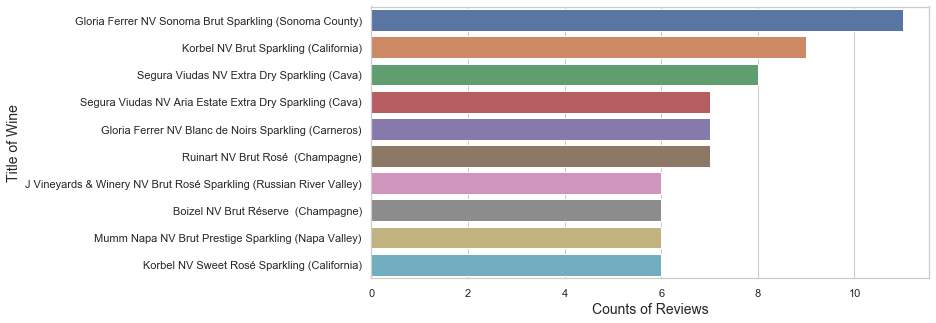

In [26]:
# Title
# Visualize counts of wines which were reviewed the most (showing only top 10)
series=(df['title'].value_counts().head(10))
plt.figure(figsize=(10,5))
sns.set(style="whitegrid")
ax = sns.barplot(y=series.index , x=series.values)
ax.set_xlabel("Counts of Reviews",fontsize=14)
ax.set_ylabel("Title of Wine",fontsize=14)
plt.show()

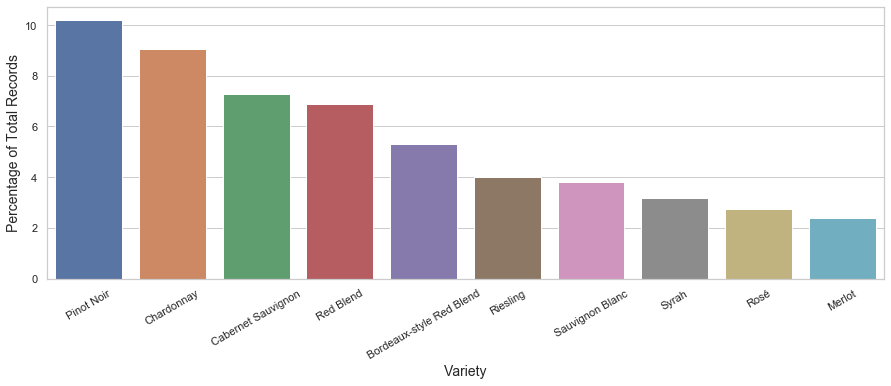

In [27]:
# Variety
# Visualize percentage of data entries of different varieties of wines present in the dataset (showing only top 10)
series=(df['variety'].value_counts().head(10) / len(df))
plt.figure(figsize=(15,5))
sns.set(style="whitegrid")
ax = sns.barplot(x=series.index , y=series.values*100)
ax.set_xlabel("Variety",fontsize=14)
ax.set_ylabel("Percentage of Total Records",fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.show()

In [28]:
# the top 60 wine varieties cover over 90% of all reviews in the dataset
df['variety'].value_counts()[:60].sum() / len(df)

0.9067715105677421

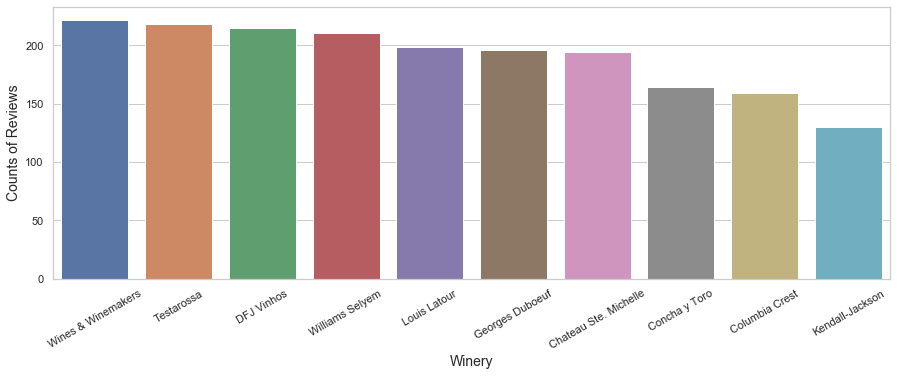

In [29]:
# Winery
# Visualize counts of different wineries present in the dataset (showing only top 10)
series=(df['winery'].value_counts().head(10))
plt.figure(figsize=(15,5))
sns.set(style="whitegrid")
ax = sns.barplot(x=series.index , y=series.values)
ax.set_xlabel("Winery",fontsize=14)
ax.set_ylabel("Counts of Reviews",fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.show()

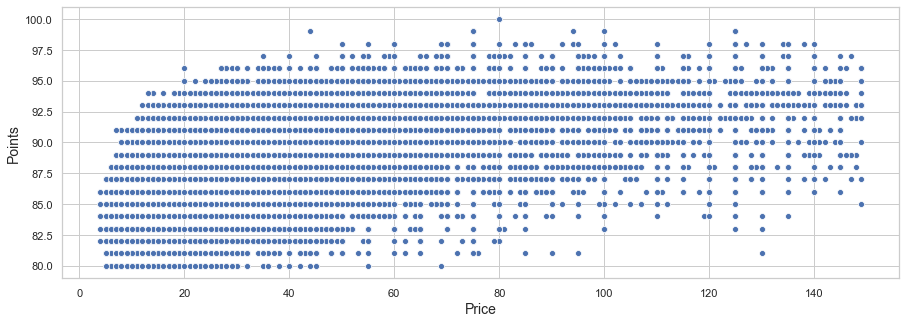

In [30]:
# Scatter plot showing points of wines with prices less than 150.
series_x=df[df['price'] < 150]['price']
series_y=df[df['price'] < 150]['points']
plt.figure(figsize=(15,5))
sns.set(style="whitegrid")
ax = sns.scatterplot(x=series_x, y=series_y)
ax.set_xlabel("Price",fontsize=14)
ax.set_ylabel("Points",fontsize=14)
plt.show()

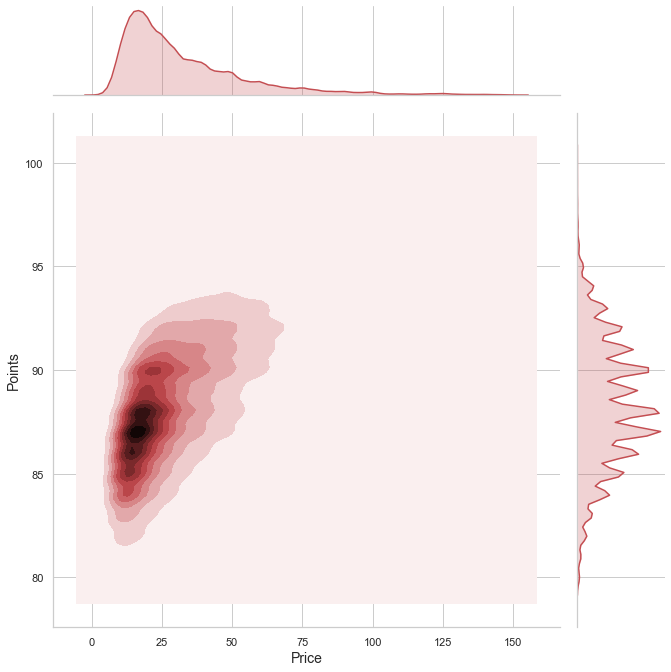

In [31]:
# Jointplot showing intersection of densities of points and prices
series_x=df[df['price'] < 150]['price'] # only less than 150 as most wines are less than 150
series_y=df[df['price'] < 150]['points']

sns.set(style="whitegrid")
g = sns.jointplot(x=series_x, y=series_y, kind="kde", color="r")
g.fig.set_figwidth(10)
g.fig.set_figheight(10)
g.set_axis_labels("Price", "Points", fontsize=14)
plt.show()

In [32]:
#-------------------------------Visualizatio Over, Now Classification---------------------------------#

In [33]:
# I am taking my classification task to be to predict the country of origin of the wine, given its description.
# I will also be performing regression to predict 'points', given description, but that comes later.

In [34]:
# deleting columns we will not use
df.drop(df.columns.difference(['index','description','country','points']), axis=1, inplace=True)
df.shape

(129971, 3)

In [35]:
df.describe(include='all')

,country,description,points
count,129908,129971,129971.000000
unique,43,119955,NaN
top,US,"Stalky aromas suggest hay and green herbs, wit...",NaN
freq,54504,3,NaN
mean,NaN,NaN,88.447138
std,NaN,NaN,3.039730
min,NaN,NaN,80.000000
25%,NaN,NaN,86.000000
50%,NaN,NaN,88.000000
75%,NaN,NaN,91.000000


In [36]:
df.dropna(inplace=True)
df.shape

(129908, 3)

In [37]:
df.drop_duplicates(subset='description', inplace=True)
df.shape

(119896, 3)

In [38]:
# function that takes description string as input and 
# outputs string of lemmas of the words in the description
def normalize_text(description):
    description = nlp(description)
    lemmatized = list()
    for word in description:
        if not word.is_punct:
            lemma = word.lemma_
            if lemma and not word.is_stop:
                lemmatized.append(lemma.lower())
    return ' '.join(lemmatized)

In [39]:
df['description_normalized'] = df['description'].apply(lambda x: normalize_text(str(x)))

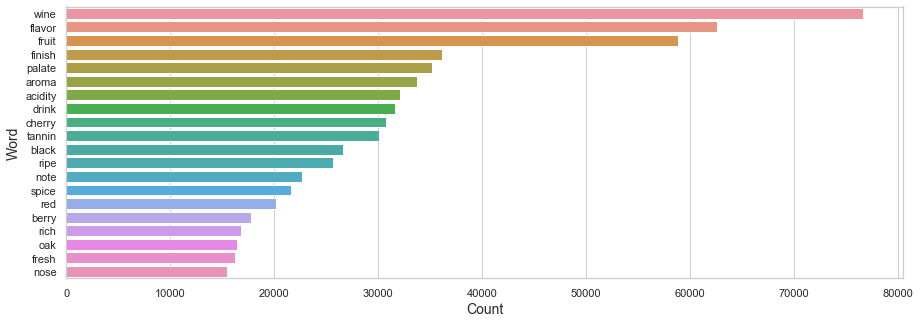

In [40]:
# Visualize most frequent words in the description
def freq_words(x, terms = 20): 
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split() 

    # most common tokens
    word_freq = Counter(all_words)
    common_words = dict(word_freq.most_common(terms))
    words_df = pd.DataFrame({'word':list(common_words.keys()), 'count':list(common_words.values())})

    # selecting top 50 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 

    # visualize words and frequencies
    plt.figure(figsize=(15,5)) 
    sns.set(style="whitegrid")
    ax = sns.barplot(x=d['count'], y=d['word']) 
    ax.set_xlabel("Count",fontsize=14)
    ax.set_ylabel("Word",fontsize=14)
    plt.show()

# show 20 most frequent words
freq_words(df['description_normalized'], 20)

In [41]:
df['country'].value_counts()

US                        50448
France                    20351
Italy                     17921
Spain                      6116
Portugal                   5256
Chile                      4184
Argentina                  3543
Austria                    3033
Australia                  2197
Germany                    1992
South Africa               1301
New Zealand                1278
Israel                      466
Greece                      431
Canada                      226
Bulgaria                    132
Hungary                     129
Romania                     102
Uruguay                      98
Turkey                       81
Slovenia                     77
Georgia                      76
Croatia                      70
Mexico                       68
England                      63
Moldova                      56
Brazil                       49
Lebanon                      32
Morocco                      24
Peru                         16
Ukraine                      14
Macedoni

In [42]:
# inputs dataframe and removes rows with reviews of wines from countries having 
# count less than 0.1% of sample size (very insignificant, less useful for training)
def remove_records_of_countries_having_low_count(df):
    minimum_country_count = 0.001*len(df) # 0.1 percent

    print('No. of countries having low count of reviews (less than 0.1%% of sample size):', \
        (df['country'].value_counts() < minimum_country_count).sum())

    countries_counts = df['country'].value_counts()
    countries_with_insignificant_counts = [i for i in countries_counts.index \
                                            if countries_counts[i] < minimum_country_count]

    print('\nRemoving', df[df['country'].isin(countries_with_insignificant_counts)].shape[0], \
        'records in hope of better model fitting.')

    df.drop(df[df['country'].isin(countries_with_insignificant_counts)].index, inplace=True)

remove_records_of_countries_having_low_count(df)

No. of countries having low count of reviews (less than 0.1%% of sample size): 26

Removing 892 records in hope of better model fitting.


In [43]:
# Use normalised description as input feature set
X = df['description_normalized']

# Create TF-IDF features using TfidfVectorizer
# Remove corpus-specific stopwords by setting max_df=0.25 as frequency graph above 
# shows uninformative words over counts > 30,000
# Keeping max_features as 100000 (actually 687888 in bigram model)
# Using both unigrams and bigrams as features in language model, hence ngram_range=(1, 2)
tfidf_vectorizer = TfidfVectorizer(max_df=0.25, max_features=100000, ngram_range=(1, 2))
X_tfidf = tfidf_vectorizer.fit_transform(X)

# labelling our target countries
le = LabelEncoder()
y = le.fit_transform(df['country'])

# split dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, \
                                                    stratify=y, random_state=10)

In [44]:
clf = MultinomialNB(alpha=0.01) # manually tuned alpha
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred, average='micro'))

              precision    recall  f1-score   support

           0       0.51      0.41      0.45       709
           1       0.64      0.54      0.59       440
           2       0.63      0.59      0.61       607
           3       1.00      0.15      0.27        26
           4       0.00      0.00      0.00        45
           5       0.56      0.45      0.50       837
           6       0.83      0.83      0.83      4070
           7       0.58      0.76      0.66       398
           8       0.67      0.65      0.66        86
           9       1.00      0.23      0.38        26
          10       0.90      0.51      0.65        93
          11       0.99      0.95      0.97      3584
          12       0.75      0.52      0.61       256
          13       0.84      0.55      0.67      1051
          14       0.62      0.67      0.65       260
          15       0.62      0.71      0.67      1223
          16       0.90      0.97      0.93     10090

    accuracy              

In [45]:
clf = LogisticRegression(solver='lbfgs', max_iter=500, multi_class='multinomial')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred, average='micro'))

              precision    recall  f1-score   support

           0       0.68      0.38      0.49       709
           1       0.71      0.42      0.53       440
           2       0.82      0.54      0.65       607
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        45
           5       0.65      0.50      0.57       837
           6       0.79      0.90      0.84      4070
           7       0.74      0.54      0.62       398
           8       0.77      0.23      0.36        86
           9       0.00      0.00      0.00        26
          10       1.00      0.20      0.34        93
          11       0.97      0.95      0.96      3584
          12       0.84      0.38      0.52       256
          13       0.89      0.46      0.61      1051
          14       0.72      0.41      0.52       260
          15       0.67      0.75      0.71      1223
          16       0.87      0.98      0.92     10090

    accuracy              

/Users/ritviksharma/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [46]:
clf = LinearSVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred, average='micro'))

              precision    recall  f1-score   support

           0       0.59      0.48      0.53       709
           1       0.71      0.58      0.64       440
           2       0.81      0.66      0.72       607
           3       0.80      0.15      0.26        26
           4       0.00      0.00      0.00        45
           5       0.62      0.53      0.57       837
           6       0.82      0.89      0.86      4070
           7       0.75      0.64      0.69       398
           8       0.79      0.62      0.69        86
           9       1.00      0.38      0.56        26
          10       0.89      0.44      0.59        93
          11       0.97      0.97      0.97      3584
          12       0.74      0.55      0.63       256
          13       0.82      0.56      0.67      1051
          14       0.69      0.64      0.66       260
          15       0.69      0.74      0.72      1223
          16       0.91      0.98      0.94     10090

    accuracy              

In [47]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred, average='micro'))

              precision    recall  f1-score   support

           0       0.59      0.06      0.11       709
           1       0.75      0.10      0.18       440
           2       0.86      0.16      0.26       607
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        45
           5       0.68      0.14      0.24       837
           6       0.73      0.84      0.78      4070
           7       0.73      0.11      0.19       398
           8       0.00      0.00      0.00        86
           9       0.00      0.00      0.00        26
          10       0.00      0.00      0.00        93
          11       0.96      0.84      0.90      3584
          12       0.93      0.05      0.10       256
          13       0.98      0.13      0.23      1051
          14       0.50      0.01      0.02       260
          15       0.60      0.40      0.48      1223
          16       0.69      0.99      0.81     10090

    accuracy              

/Users/ritviksharma/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [48]:
# As LinearSVC looked the most promising from above, I chose to autotune it.
# Set the parameters for GridSearch for tuning LinearSVC
param_grid = [{'penalty': ['l1', 'l2'], \
              'dual': [False], 
              'C': [0.1, 1, 10]},
              {'penalty': ['l2'], \
              'dual': [True], \
              'C': [0.1, 1, 10]}]

clf = GridSearchCV(LinearSVC(), param_grid, cv=5, scoring='f1_micro')

clf.fit(X_train, y_train)

print("Best tuned parameters for the development set:")
print(clf.best_params_)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred, average='micro'))

/Users/ritviksharma/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Best tuned parameters for the development set:
{'C': 1, 'dual': False, 'penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.59      0.48      0.53       709
           1       0.71      0.58      0.64       440
           2       0.81      0.66      0.72       607
           3       0.80      0.15      0.26        26
           4       0.00      0.00      0.00        45
           5       0.62      0.53      0.57       837
           6       0.83      0.89      0.86      4070
           7       0.75      0.64      0.69       398
           8       0.79      0.62      0.69        86
           9       1.00      0.38      0.56        26
          10       0.89      0.44      0.59        93
          11       0.97      0.97      0.97      3584
          12       0.74      0.55      0.63       256
          13       0.82      0.56      0.67      1051
          14       0.69      0.64      0.66       260
          15       0.69      0.74      0.72    

/Users/ritviksharma/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [49]:
clf = LinearSVC(C=1, dual=False, penalty='l2') # tuned using GridSearchCV
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred, average='micro'))

              precision    recall  f1-score   support

           0       0.59      0.48      0.53       709
           1       0.71      0.58      0.64       440
           2       0.81      0.66      0.72       607
           3       0.80      0.15      0.26        26
           4       0.00      0.00      0.00        45
           5       0.62      0.53      0.57       837
           6       0.83      0.89      0.86      4070
           7       0.75      0.64      0.69       398
           8       0.79      0.62      0.69        86
           9       1.00      0.38      0.56        26
          10       0.89      0.44      0.59        93
          11       0.97      0.97      0.97      3584
          12       0.74      0.55      0.63       256
          13       0.82      0.56      0.67      1051
          14       0.69      0.64      0.66       260
          15       0.69      0.74      0.72      1223
          16       0.91      0.98      0.94     10090

    accuracy              

In [50]:
#------------------------------------Classification Task Over--------------------------------------#

In [51]:
# Just out of curiosity, I thought it may be interesting to 
# predict the 'points' of a wine, given its 'description'. Hence,
# I am doing this using regression, as 'points' are continuous numeric values.

X = df['description_normalized']
tfidf_vectorizer = TfidfVectorizer(max_df=0.25, max_features=20000, ngram_range=(1, 2)) # manual tuning
X_tfidf = tfidf_vectorizer.fit_transform(X)

y = df['points'].astype(float)

# split dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, stratify=y, random_state=10)

# using SGDRegressor with manually tuned weights
reg = SGDRegressor(learning_rate='adaptive')

# training using training data
reg.fit(X_train, y_train)

# predicting on test data
y_pred = reg.predict(X_test)

print('MSE:', mean_squared_error(y_test, y_pred))
print('R2 Score:', r2_score(y_test, y_pred))

MSE: 3.09877277956153
R2 Score: 0.6762098267449028


In [52]:
#------------------------------------Regression Task Over--------------------------------------#